In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df_feature = pd.read_csv('features.csv', parse_dates=[1])
df_train = pd.read_csv('train.csv', parse_dates=[2])

In [3]:
# missing data
df_feature.drop(['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'], axis=1, inplace=True)
df_feature['CPI'].ffill(inplace=True)
df_feature['Unemployment'].ffill(inplace=True) 

In [81]:
df_feature_train = df_feature[df_feature['Date'].between('2010-02-05', '2012-10-26')]
df_train_group = df_train.groupby(['Store', 'Date']).mean()[['Weekly_Sales', 'IsHoliday']]
df_train_group.reset_index(inplace=True)
train = df_train_group.merge(df_feature_train, on=['Store', 'Date'])
df = train.groupby('Date').mean().drop('Store', axis=1).reset_index()

In [91]:
df = df.set_index('Date')

In [92]:
X = df.drop(['Weekly_Sales'], axis=1)
y = df['Weekly_Sales']

In [94]:
X.head()

,IsHoliday_x,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday_y
Date,,,,,,
2010-02-05,False,34.037333,2.717844,167.730885,8.619311,False
2010-02-12,True,34.151333,2.694022,167.825608,8.619311,True
2010-02-19,False,37.719778,2.672067,167.871686,8.619311,False
2010-02-26,False,39.243556,2.683933,167.909657,8.619311,False
2010-03-05,False,42.917333,2.731200,167.947628,8.619311,False


In [95]:
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
X_standard = pd.DataFrame(standard_scaler.fit_transform(X)).set_index(X.index)

In [96]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_standard, y, test_size=0.3)

In [109]:
X_train = X_standard[:114]
y_train = y[:114]
X_test = X_standard[114:]
y_test = y[114:]

In [111]:
y_train

Date
2010-02-05    16209.922128
2010-02-12    15794.946081
2010-02-19    15645.953012
2010-02-26    14397.682819
2010-03-05    15376.871198
                  ...     
2012-03-09    15462.974800
2012-03-16    15338.887015
2012-03-23    14714.933973
2012-03-30    14823.541690
2012-04-06    17323.204146
Name: Weekly_Sales, Length: 114, dtype: float64

In [112]:
from xgboost import XGBRegressor
xgb = XGBRegressor(use_label_encoder=False)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

In [113]:
def RMSPE(y_true, y_pred):
    return np.sqrt(np.nanmean(np.square(((y_true - y_pred) / y_true))))*100

In [146]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse=mean_squared_error(y_pred, y_test)
rmse = np.sqrt(mse)
print('mse', mse)
print('rmse', rmse)
print('mae', mean_absolute_error(y_pred, y_test))
print('rmspe', RMSPE(y_test, y_pred))

mse 423701.0391785992
rmse 650.9232206478728
mae 497.551515316635
rmspe 4.156745119701784


## Model Tuning

In [115]:
from sklearn.model_selection import RandomizedSearchCV
# Create the parameter grid: gbm_param_grid 
gbm_param_grid = {
    'n_estimators': range(5,20), # 樹有幾棵
    'max_depth': range(6,20), # 樹的深度
    'learning_rate': [.4, .45, .5, .55, .6],
    'colsample_bytree': [.6, .7, .8, .9, 1],
    'min_child_weight':range(1,6,2)
    }
gbm = XGBRegressor()
xgb_random = RandomizedSearchCV(param_distributions=gbm_param_grid,
                   estimator=gbm,
                    
                   cv=4) # cv是cross validation

# Fit randomized_mse to the data
xgb_random.fit(X_standard, y)

# Print the best parameters and lowest RMSE
#print("Search log: ", xgb_random.grid_scores_)
print("Best parameters found: ", xgb_random.best_params_)
#print("Best accuracy found: ", xgb_random.best_score_)

Best parameters found:  {'n_estimators': 9, 'min_child_weight': 3, 'max_depth': 18, 'learning_rate': 0.5, 'colsample_bytree': 0.9}


## Final Model

In [145]:
from xgboost import XGBRegressor
xgb = XGBRegressor(use_label_encoder=False, n_estimators=9, min_child_weight=3,max_depth=18,learning_rate=0.5,colsample_bytree=0.9)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
mse=mean_squared_error(y_pred, y_test)
rmse = np.sqrt(mse)
print('mse', mse)
print('rmse', rmse)
print('mae', mean_absolute_error(y_pred, y_test))
print('rmspe', RMSPE(y_test, y_pred))

mse 423701.0391785992
rmse 650.9232206478728
mae 497.551515316635
rmspe 4.156745119701784


In [136]:
y_pred = pd.DataFrame(y_pred, index=y_test.index)
y_pred.columns = ['y_pred']

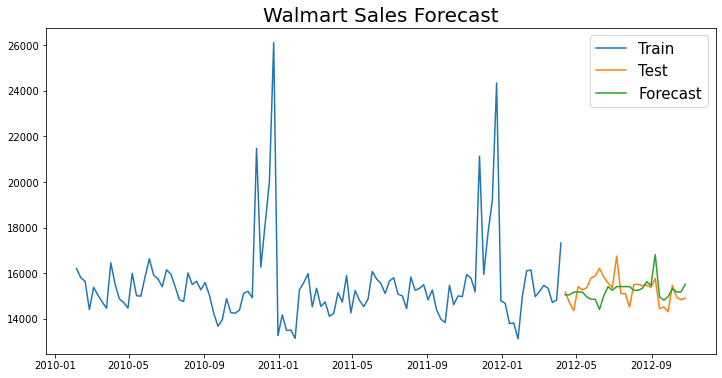

In [135]:
pd.plotting.register_matplotlib_converters()
plt.figure(figsize=(12, 6))
plt.title('Walmart Sales Forecast', fontsize=20)
plt.plot(y_train, label='Train')
plt.plot(y_test, label='Test')
plt.plot(y_pred, label='Forecast')
plt.legend(fontsize=15)
plt.show()

/Users/vivianho/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Density'}, xlabel='residual', ylabel='Density'>

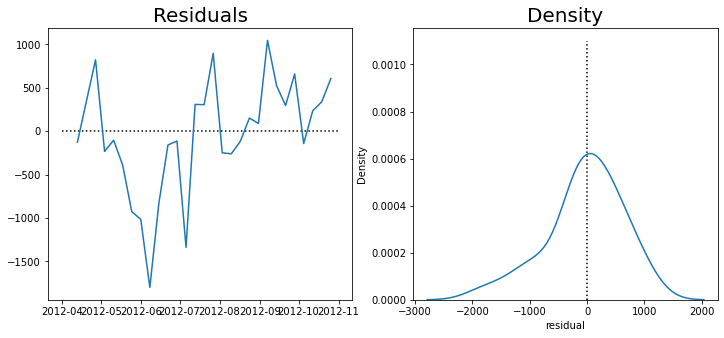

In [144]:
residual = pd.concat([y_pred['y_pred'], y_test], axis=1)
residual['residual'] = residual['y_pred']-residual['Weekly_Sales']

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('Residuals', fontsize=20)
plt.plot(residual['residual'])
plt.hlines(0,'2012-04','2012-11', color='black', linestyles='dotted')
plt.subplot(1,2,2)
plt.title('Density', fontsize=20)
plt.vlines(0,0,0.0011, color='black', linestyles='dotted')
sns.kdeplot(residual['residual'], bw=0.5)